# Explore here

In [7]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings  

warnings.filterwarnings('ignore')

np.random.seed(7)

In [8]:


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

In [9]:
df = pd.read_csv("/workspaces/Series-Temporales/data/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


Remove irrelevant information

In [10]:
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [11]:
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [12]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


Data Visualization

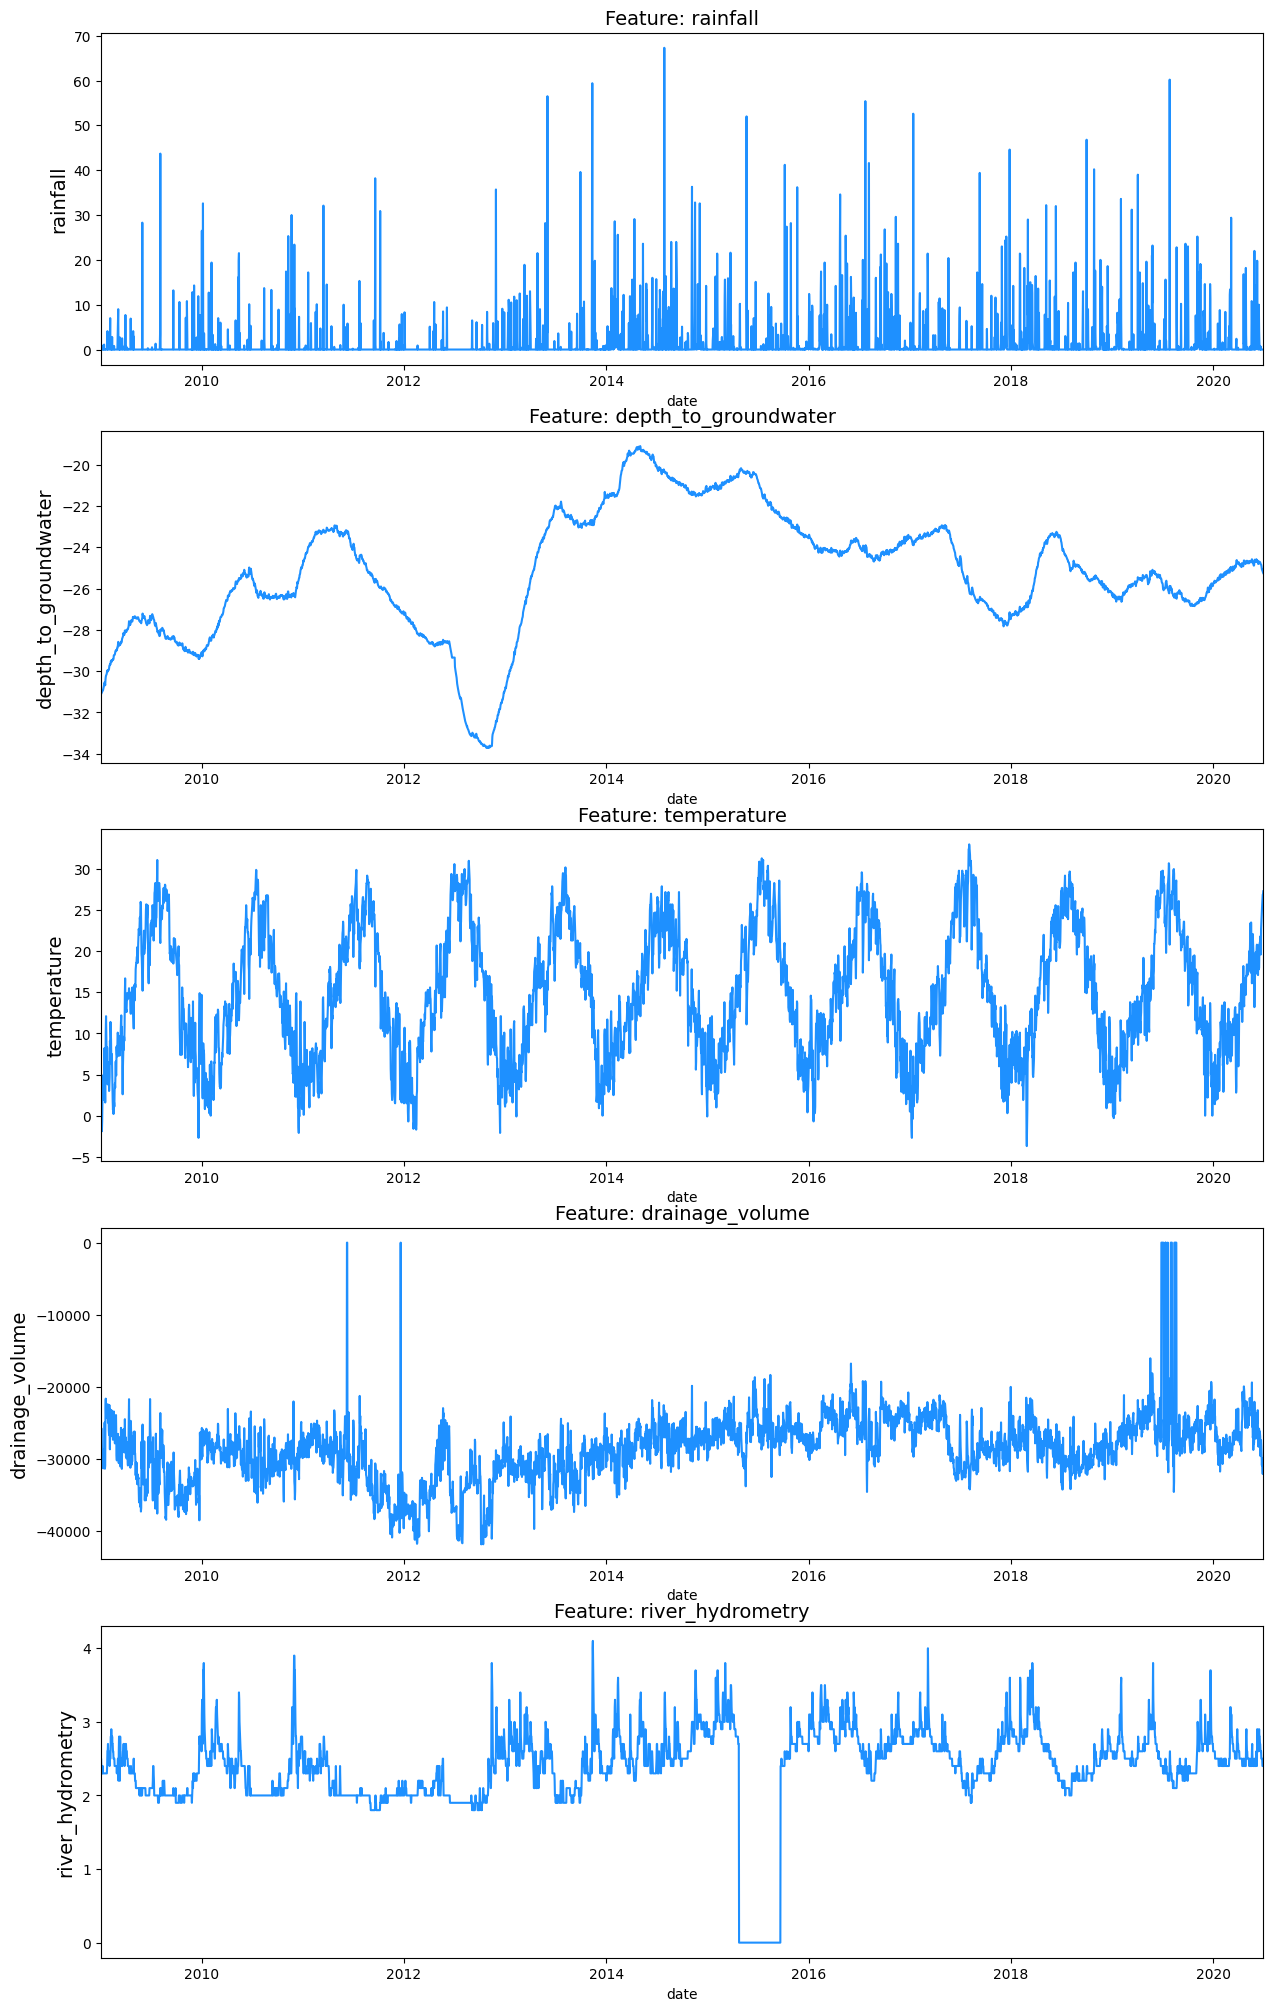

In [13]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])  

Data Processing

Applying Chronological Order for better reading of the time intervals

In [14]:
df = df.sort_values(by='date')
df['delta'] = df['date'] - df['date'].shift(1)
df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [15]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), np.int64(4198))

Removing missing values

In [16]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

Visualization of data after adjusting

(np.float64(14245.0), np.float64(18443.0))

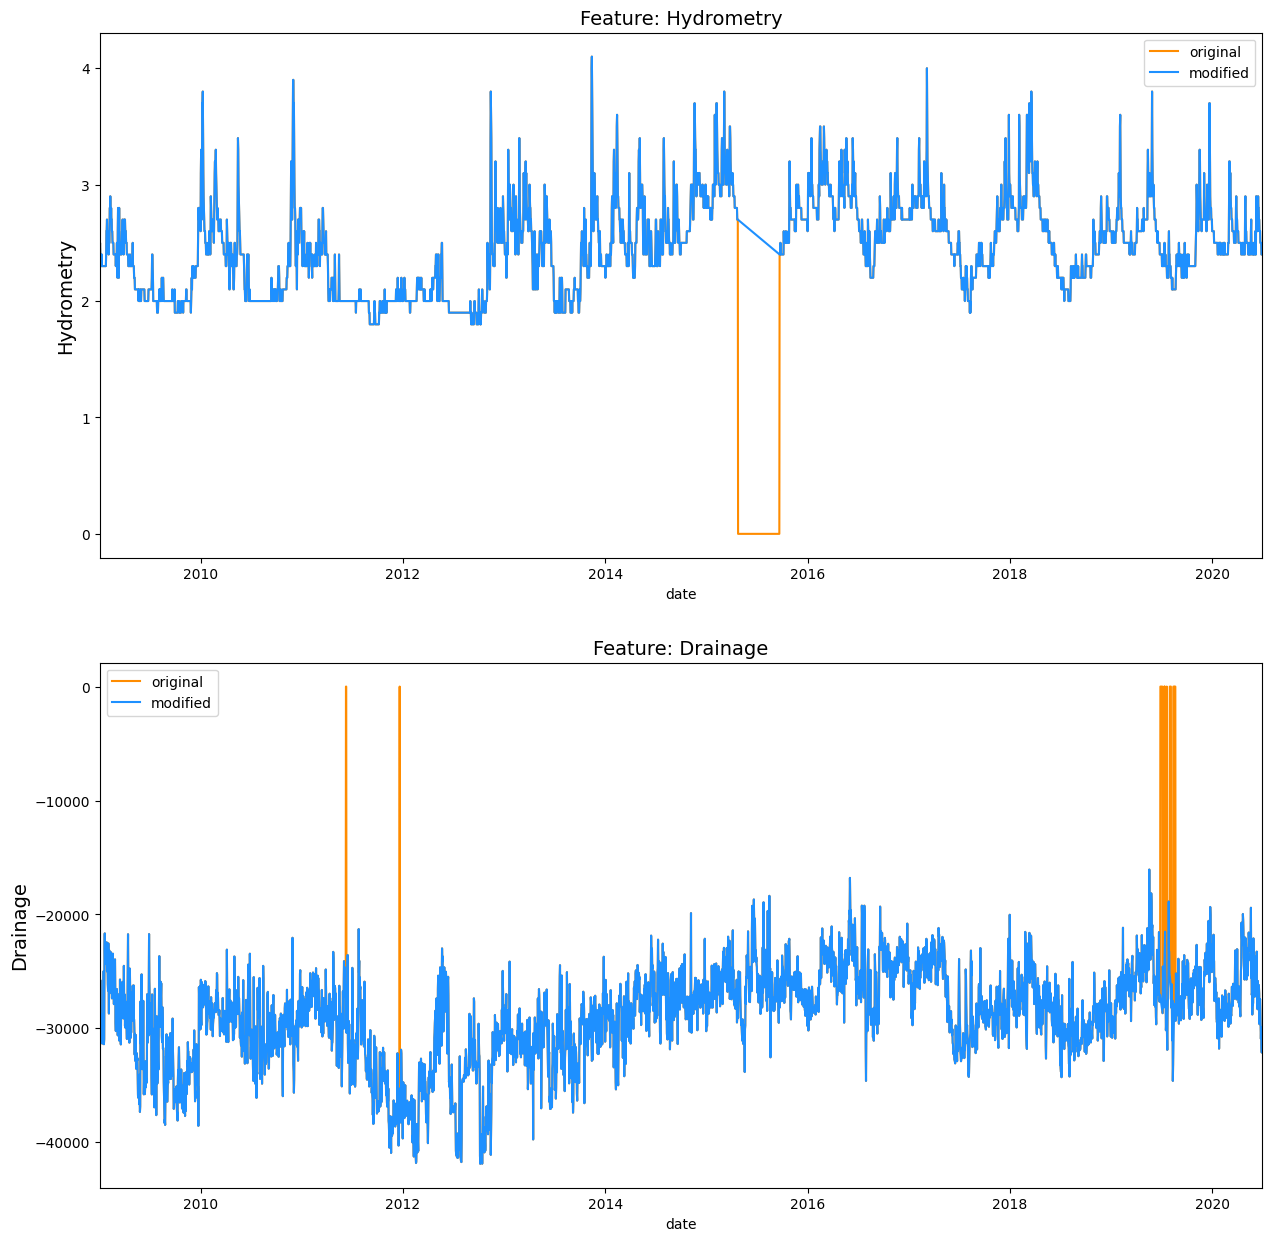

In [17]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

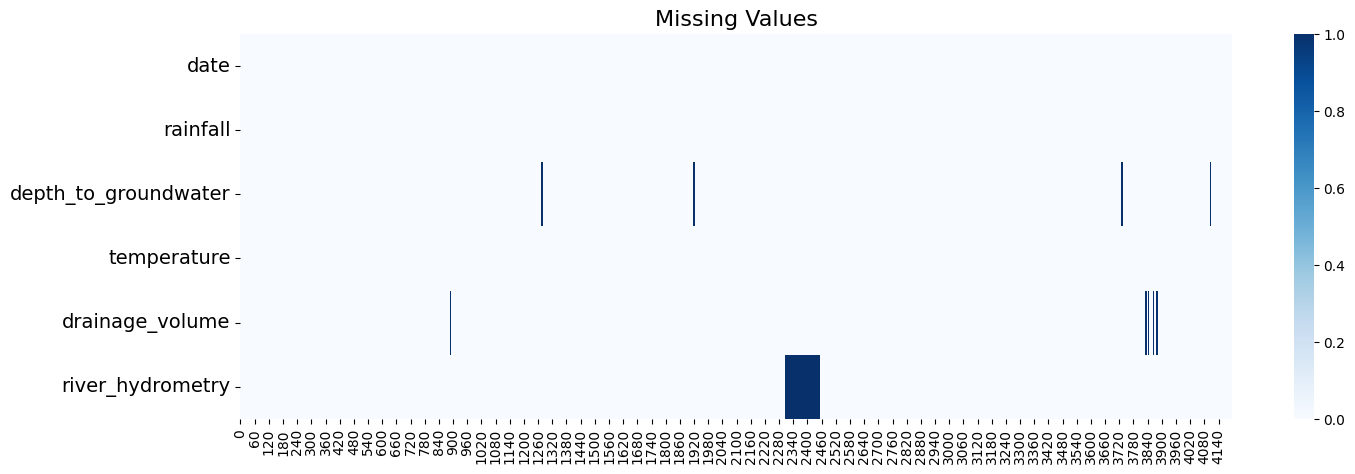

In [18]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues', ax=ax)
ax.set_title('Missing Values', fontsize=16)

for label in ax.yaxis.get_majorticklabels():
    label.set_fontsize(14)

plt.show()

We fill in the Nan values with Linearly Interpolated Value with .interpolate()

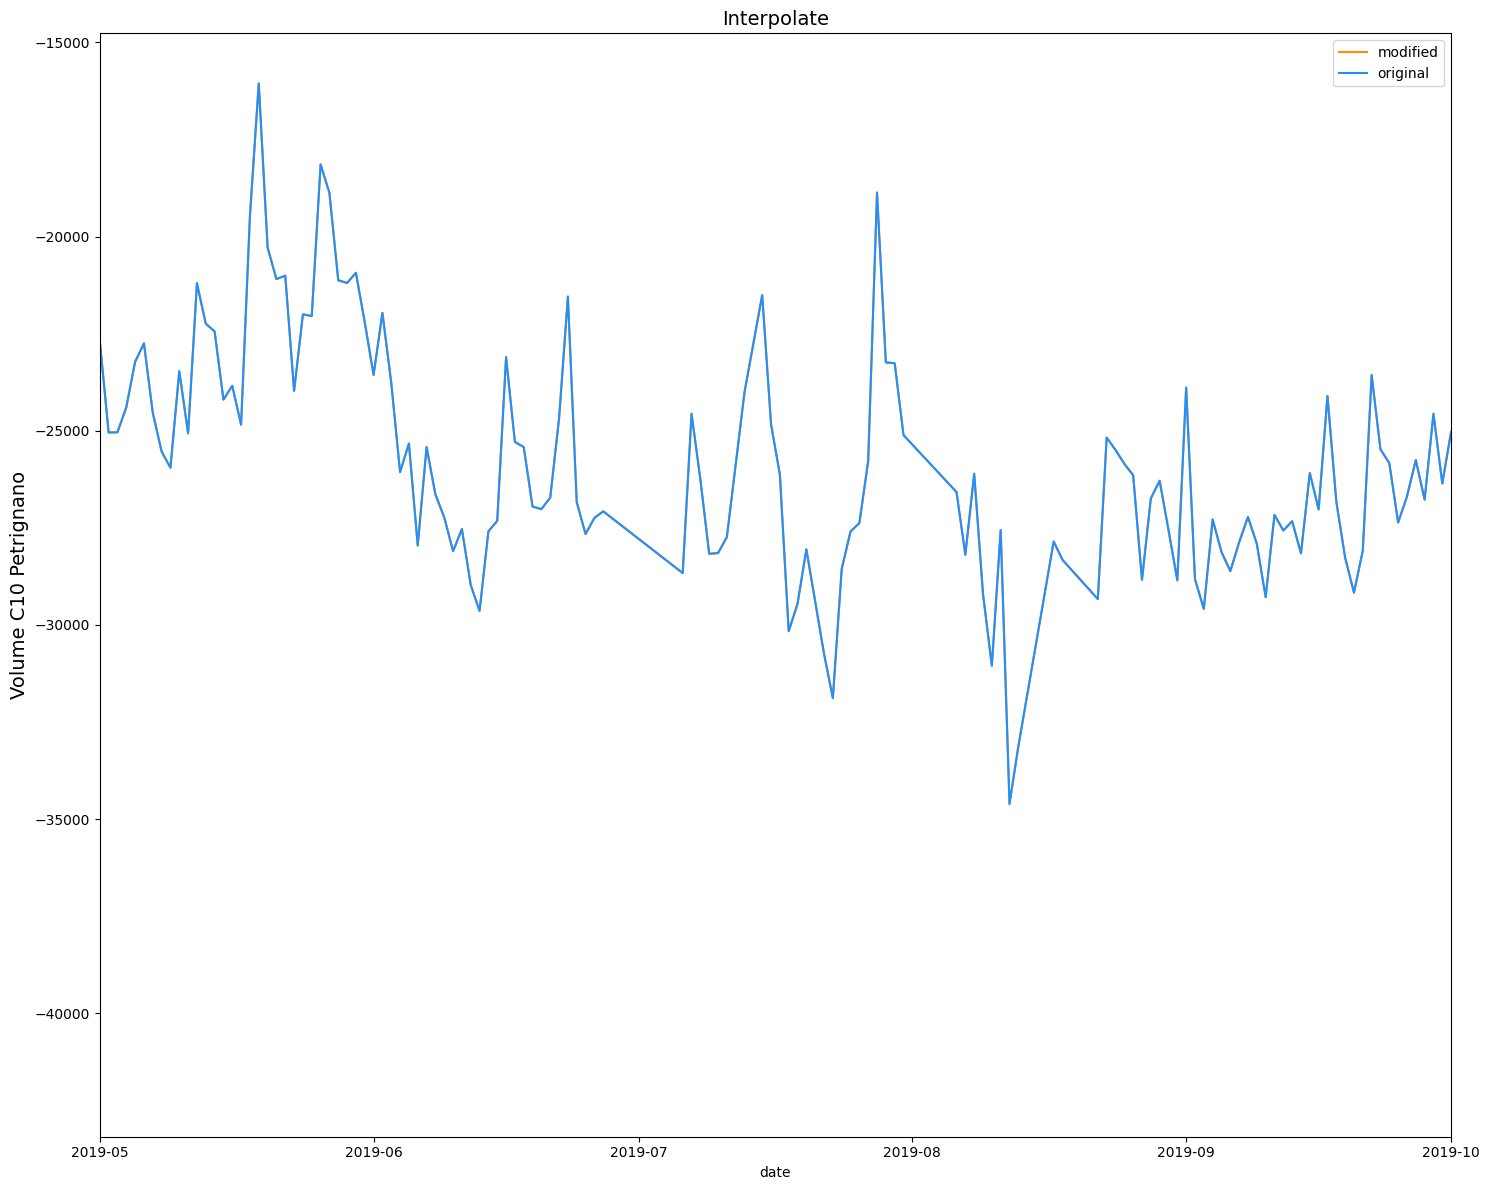

In [19]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax, color='darkorange', label='modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax, color='dodgerblue', label='original')

ax.set_title('Interpolate', fontsize=14)
ax.set_ylabel('Volume C10 Petrignano', fontsize=14)
ax.set_xlim([date(2019, 5, 1), date(2019, 10, 1)])

plt.tight_layout()
plt.show()

In [20]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

Resampling the Data

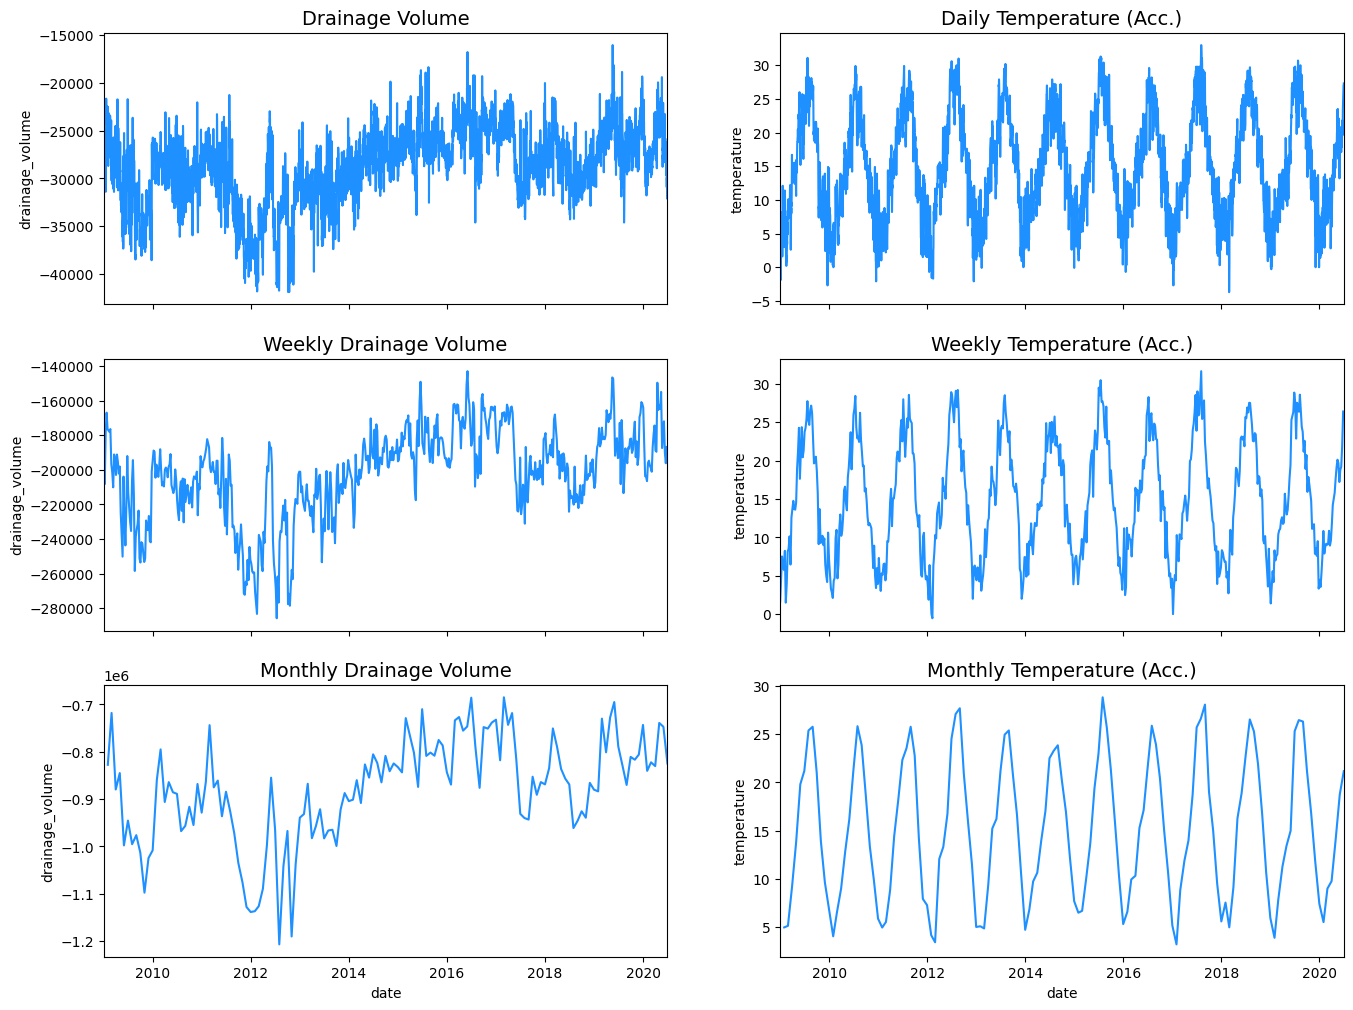

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date', 'drainage_volume']].resample('7D', on='date').sum().reset_index()
sns.lineplot(x=resampled_df['date'], y=resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date', 'drainage_volume']].resample('M', on='date').sum().reset_index()
sns.lineplot(x=resampled_df['date'], y=resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['date', 'temperature']].resample('7D', on='date').mean().reset_index()
sns.lineplot(x=resampled_df['date'], y=resampled_df['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['date', 'temperature']].resample('M', on='date').mean().reset_index()
sns.lineplot(x=resampled_df['date'], y=resampled_df['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

In [22]:
downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

Check for stationarity

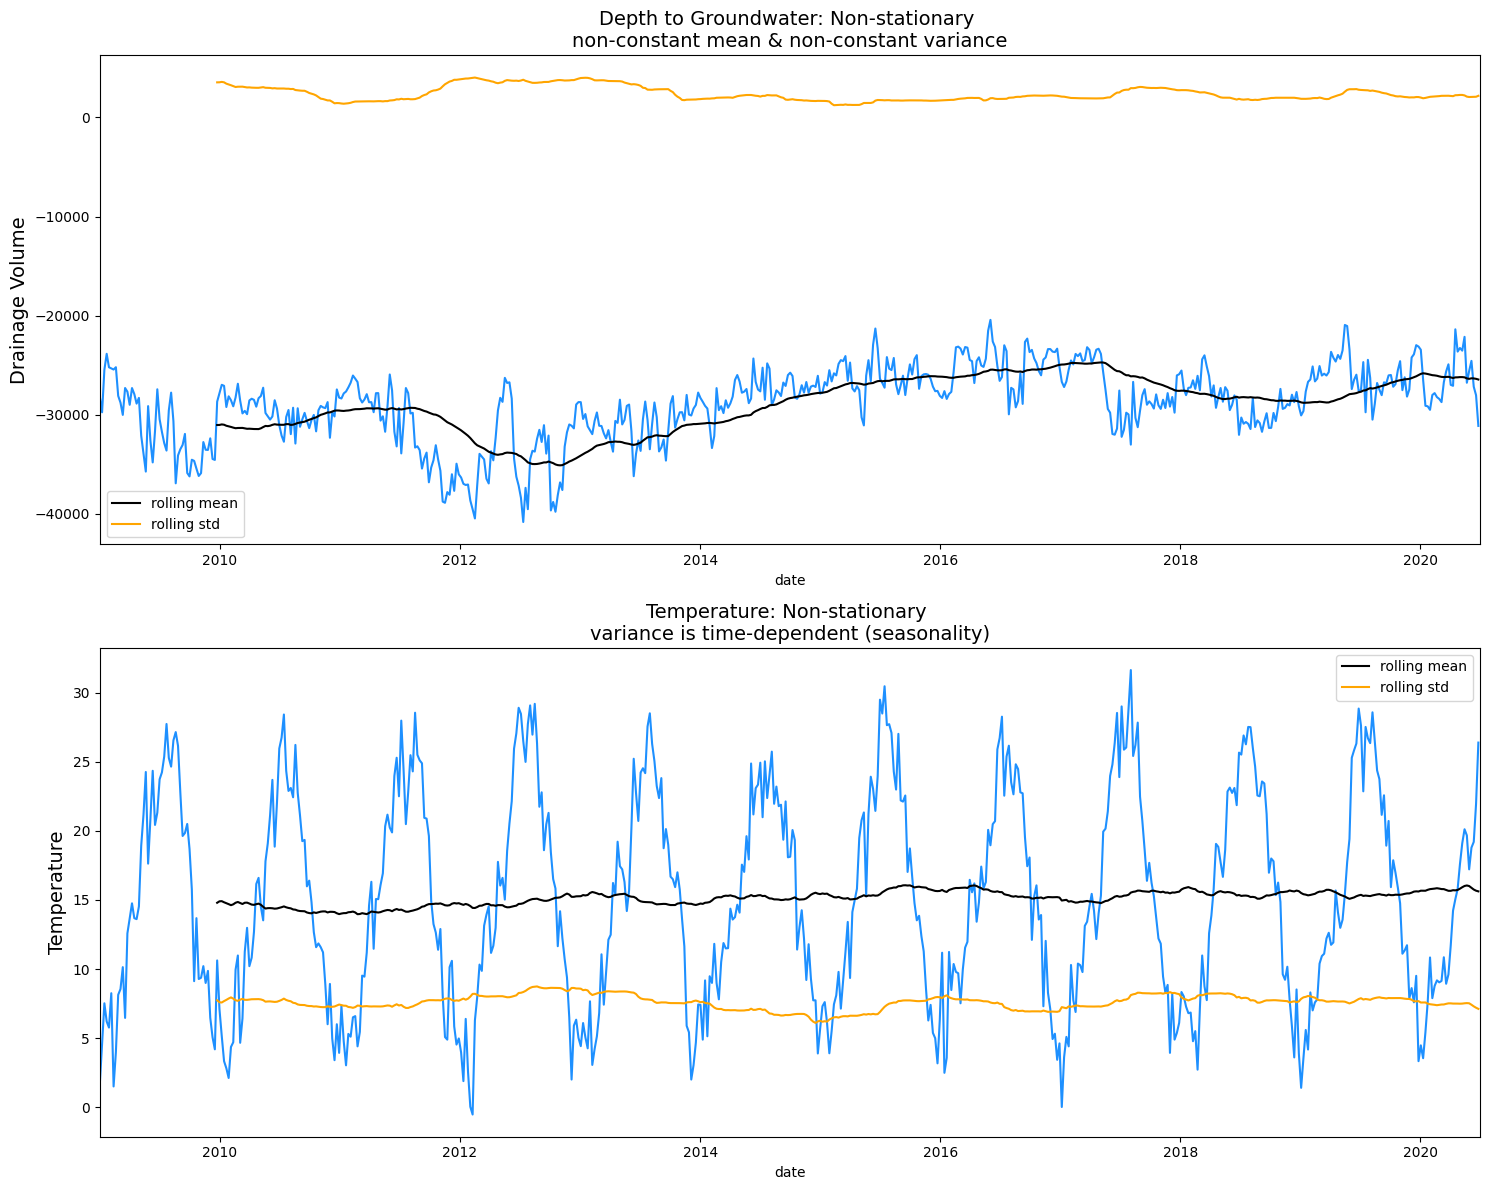

In [23]:
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

We can see that the variables do not have significant a constant mean or std.

Checking for a unit root applying ADF, see if is a non stationary time serie.

In [24]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(np.float64(-2.8802016493166605),
 np.float64(0.047699190920208856),
 7,
 592,
 {'1%': np.float64(-3.441444394224128),
  '5%': np.float64(-2.8664345376276454),
  '10%': np.float64(-2.569376663737217)},
 np.float64(-734.3154255877616))

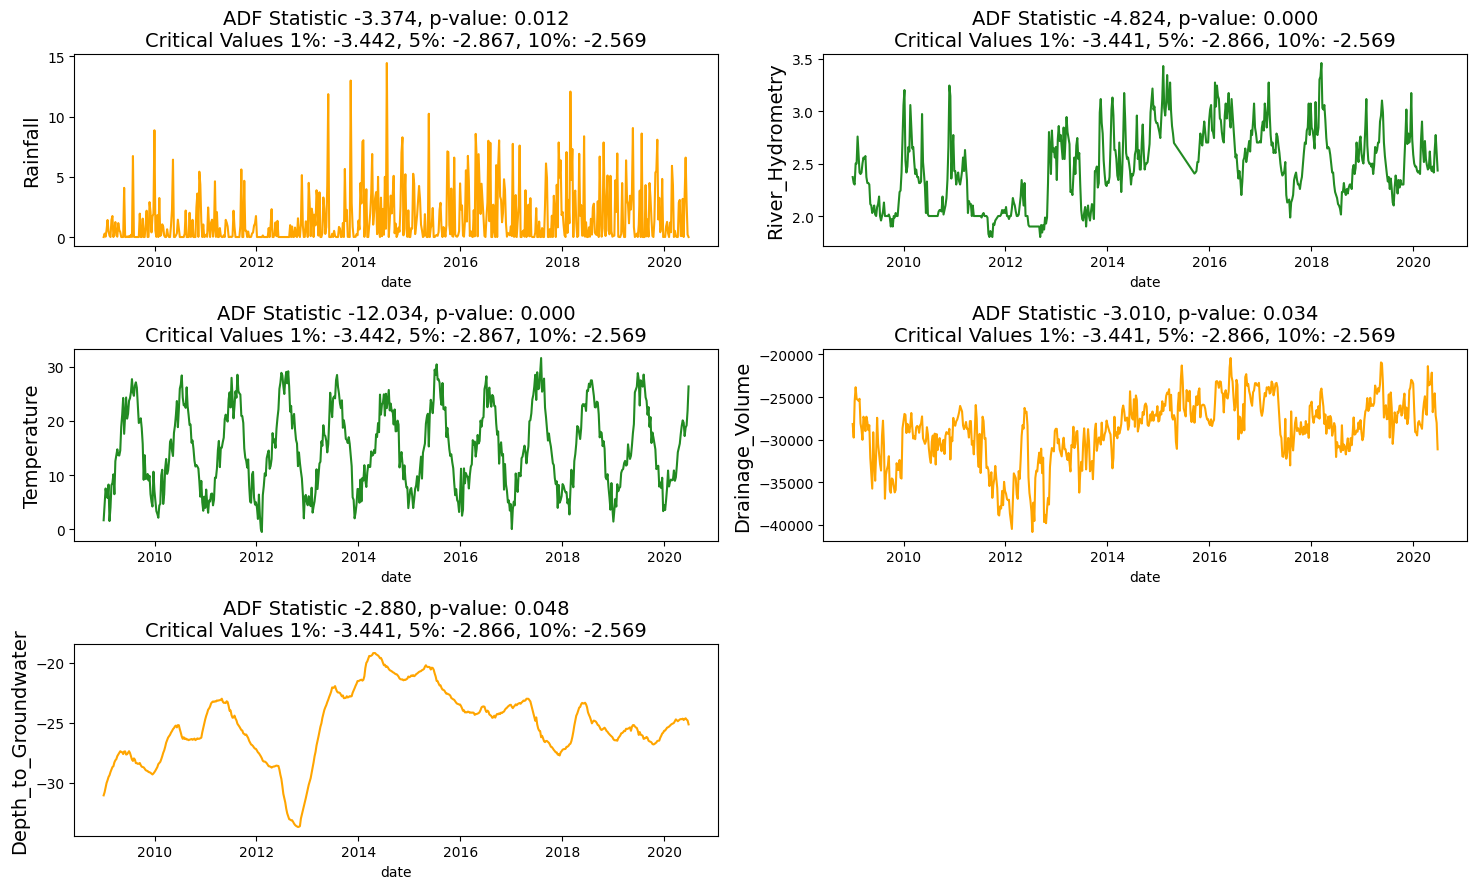

In [25]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Transforming Data

<Axes: xlabel='depth_to_groundwater_log', ylabel='Density'>

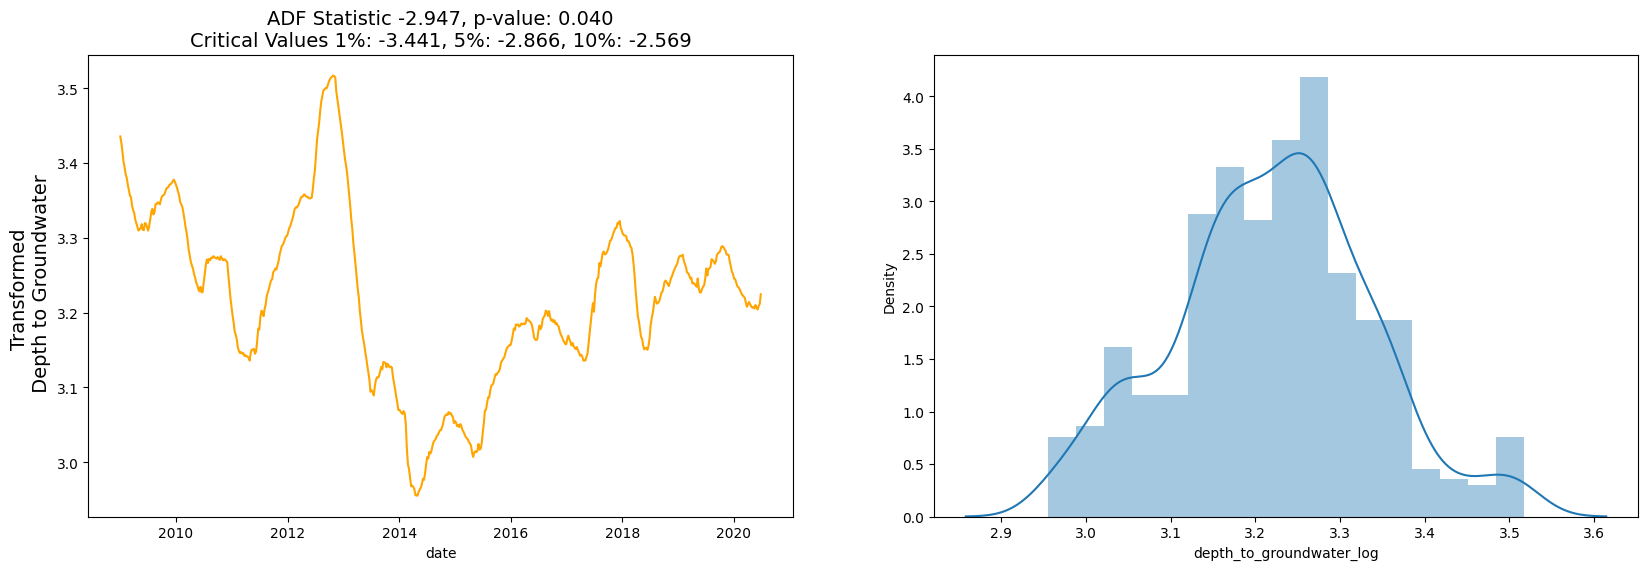

In [26]:
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

Differencing

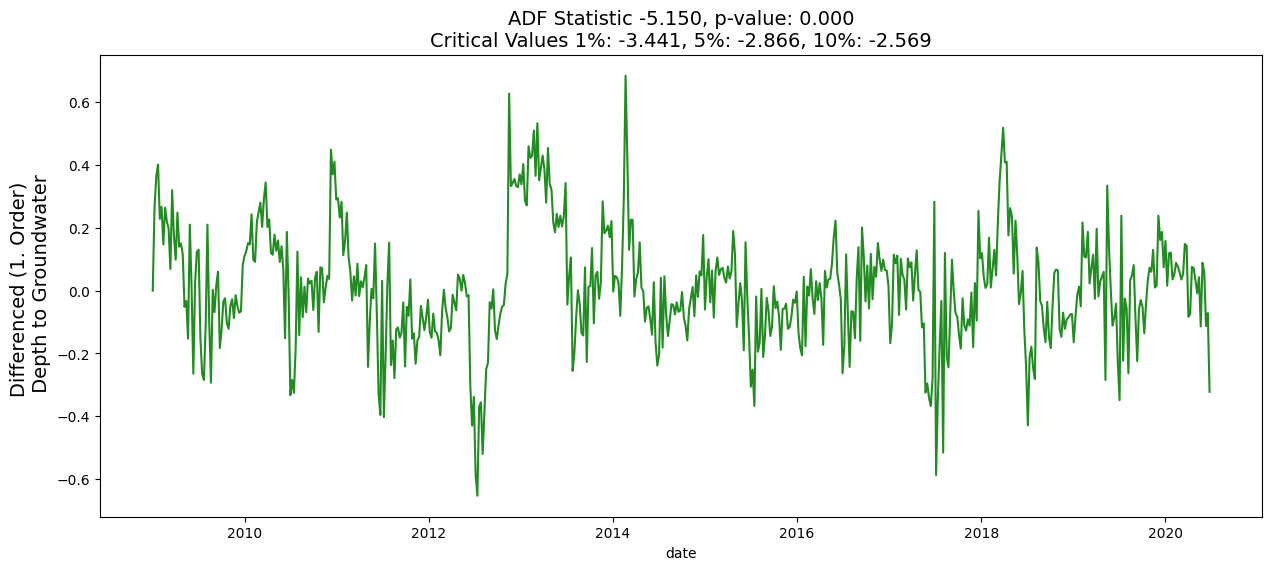

In [27]:
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

Feature Engineering

In [28]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week 
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


Encondign Cyclical Features

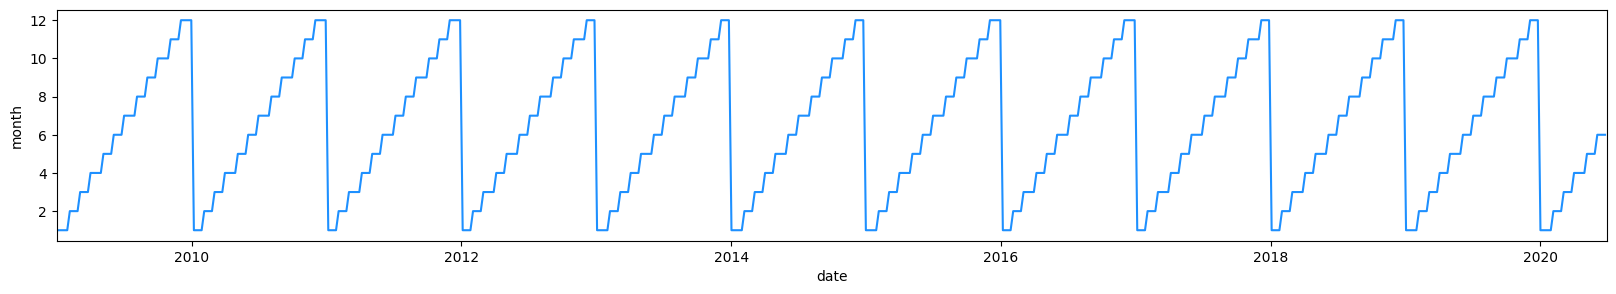

In [29]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

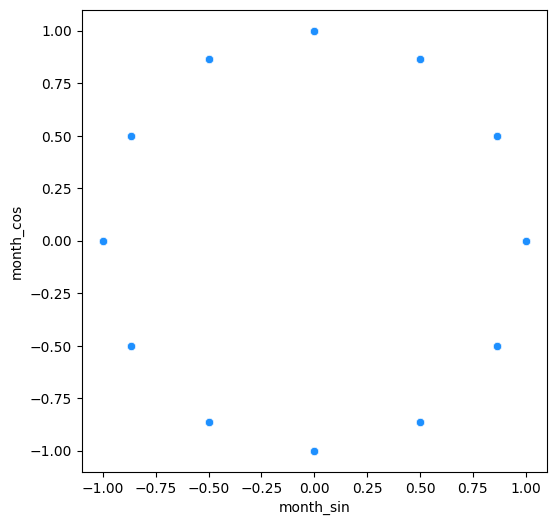

In [30]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

Time Series Decomposition by season

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

Visualization

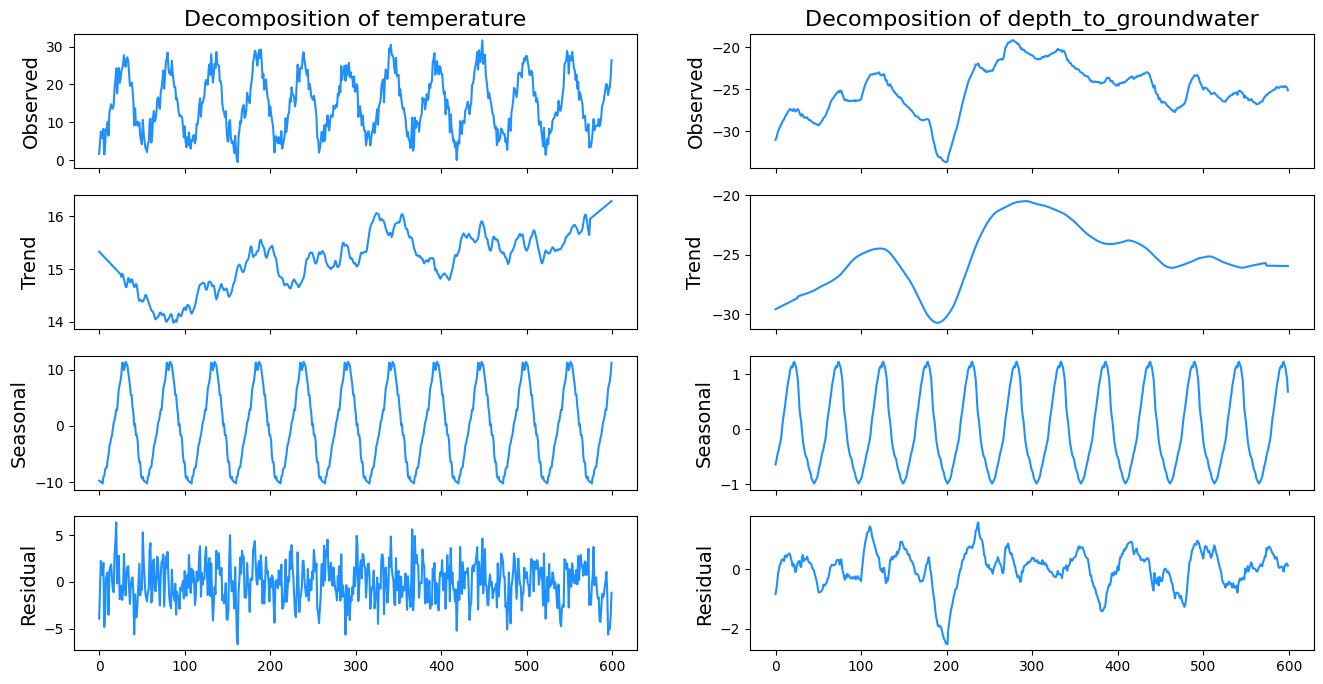

In [32]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

Now we compare the correlation with other varaibles using shift()(lag)

In [33]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

     EDA

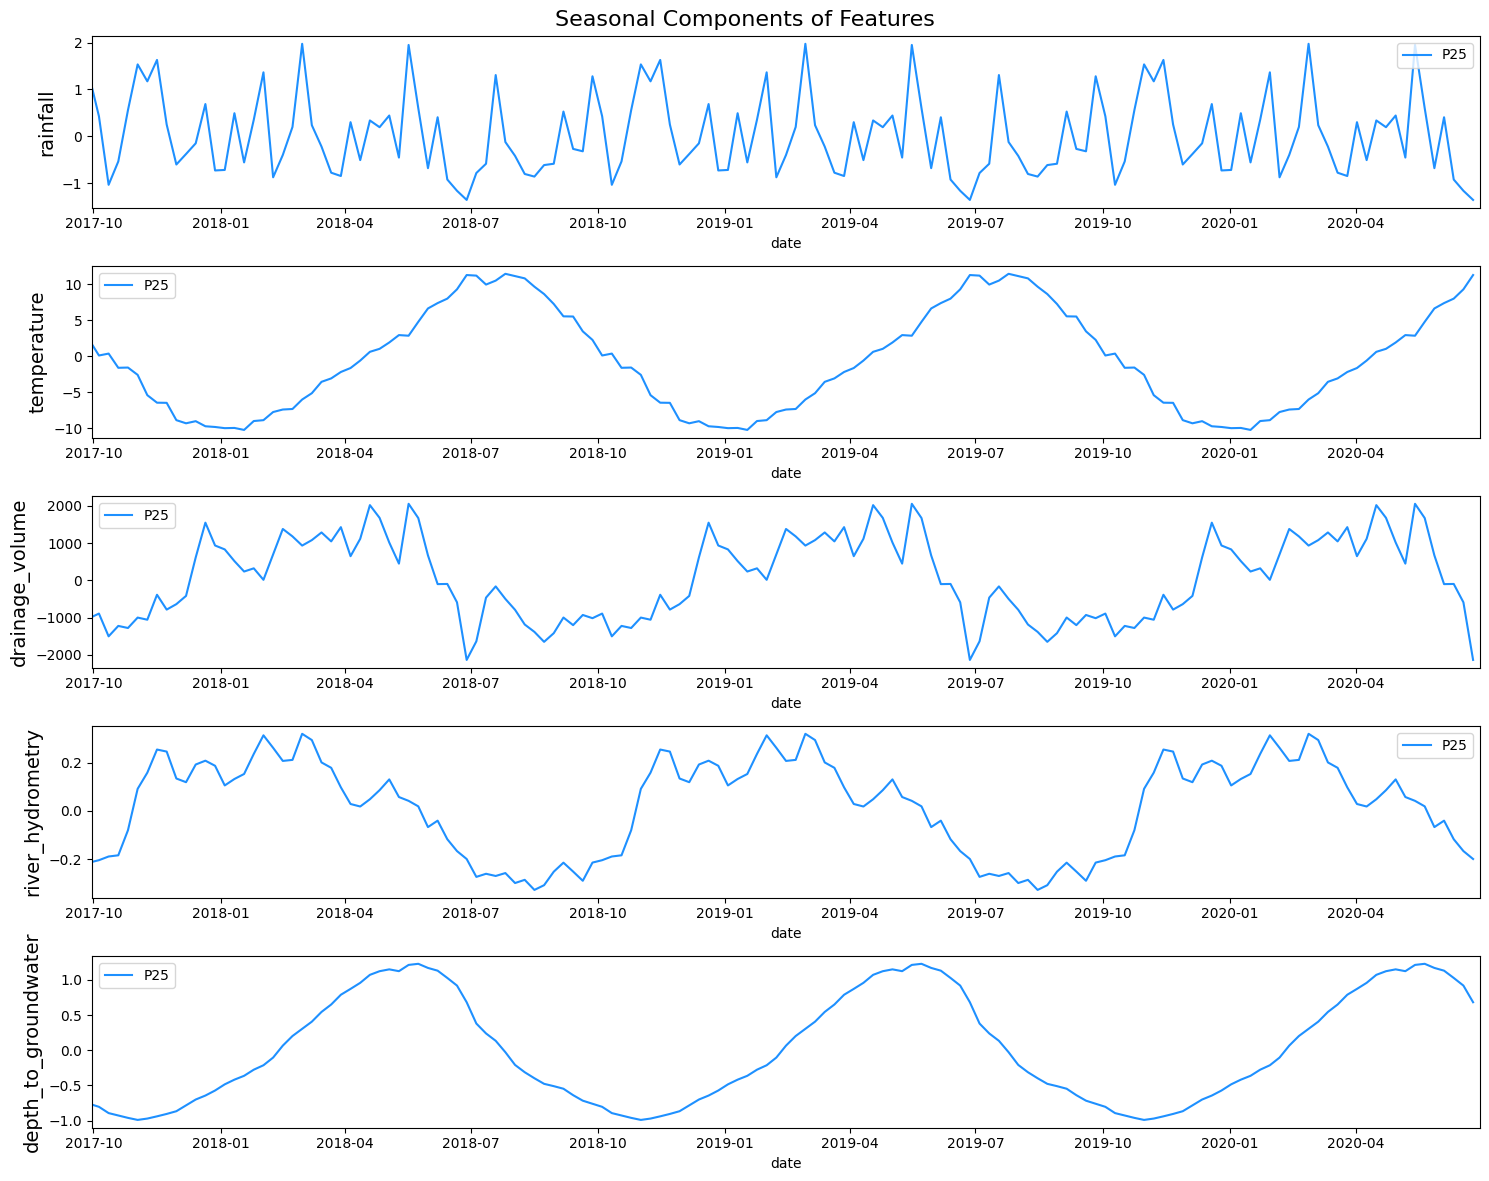

In [34]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

Variables: depth_to_groundwater: Max -> May/June, Min -> November temperature: Max -> August, Min -> January drainage_volume: Max ->Jun, Min-> July river_hydrometry: Max -> February/March, Min-> September

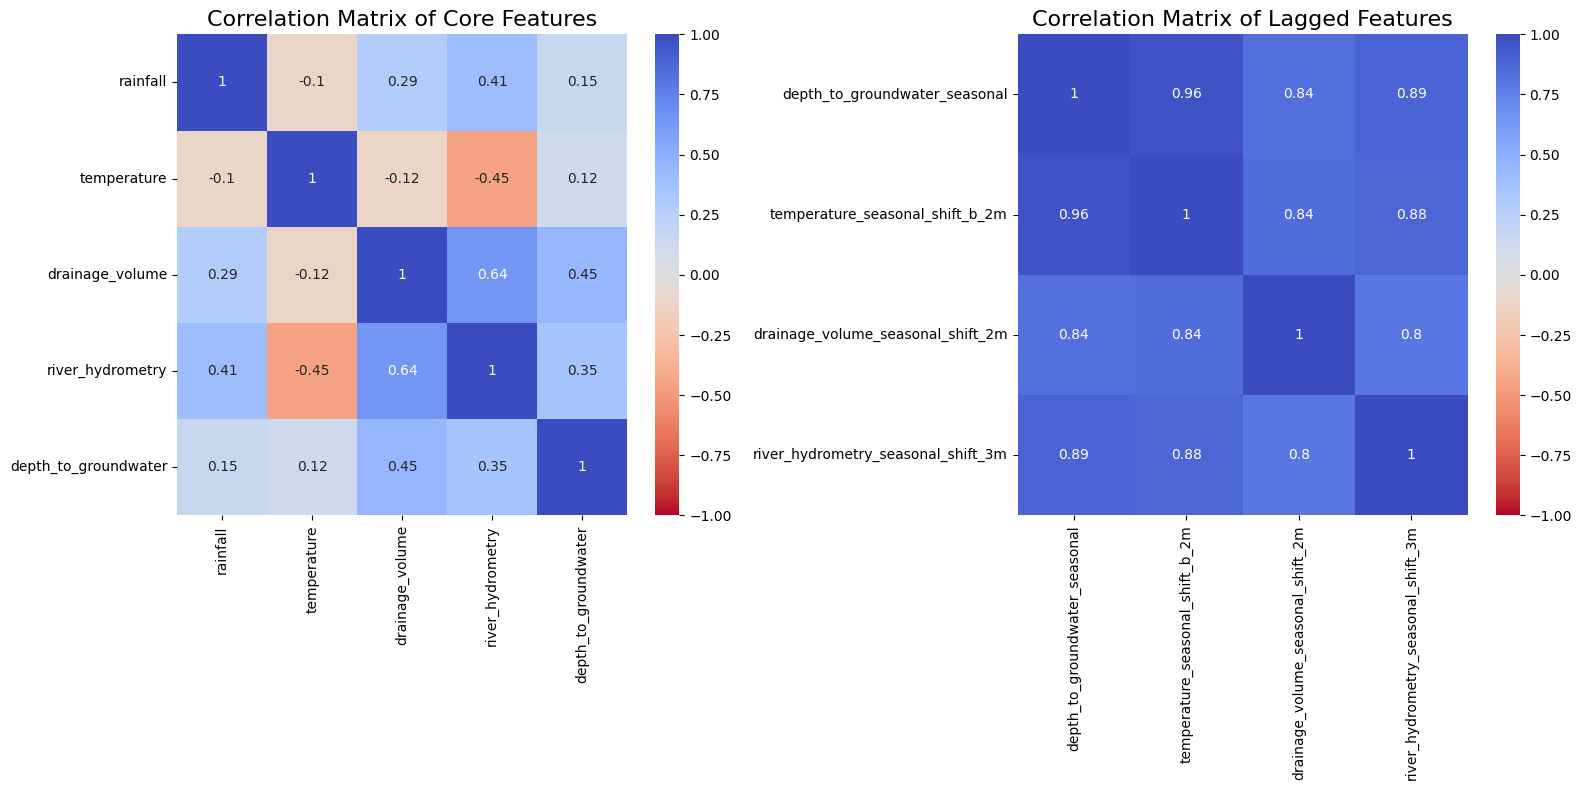

In [35]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',         
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m', 
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

Auto Correlation Analysis

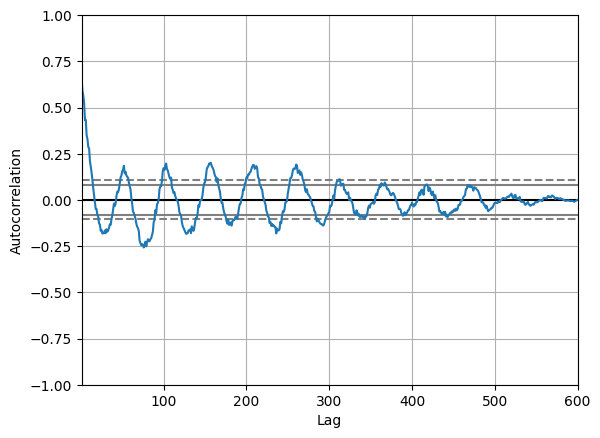

In [36]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

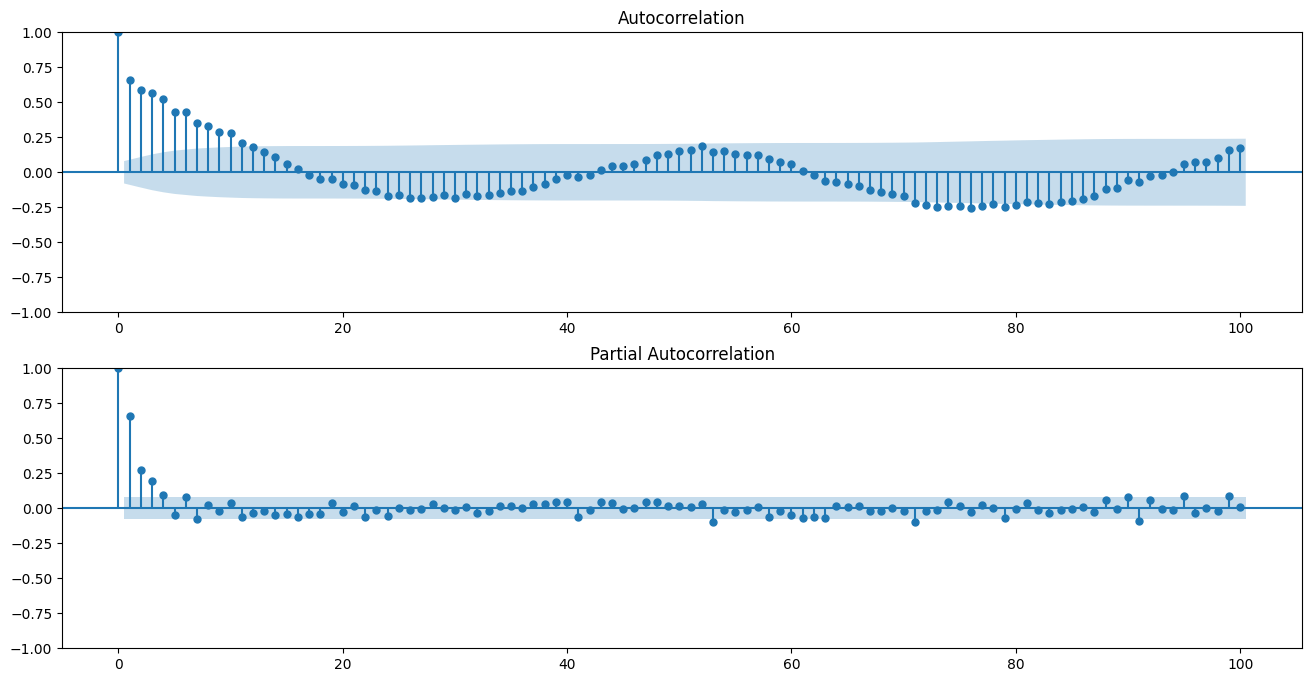

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

Modeling

In [38]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

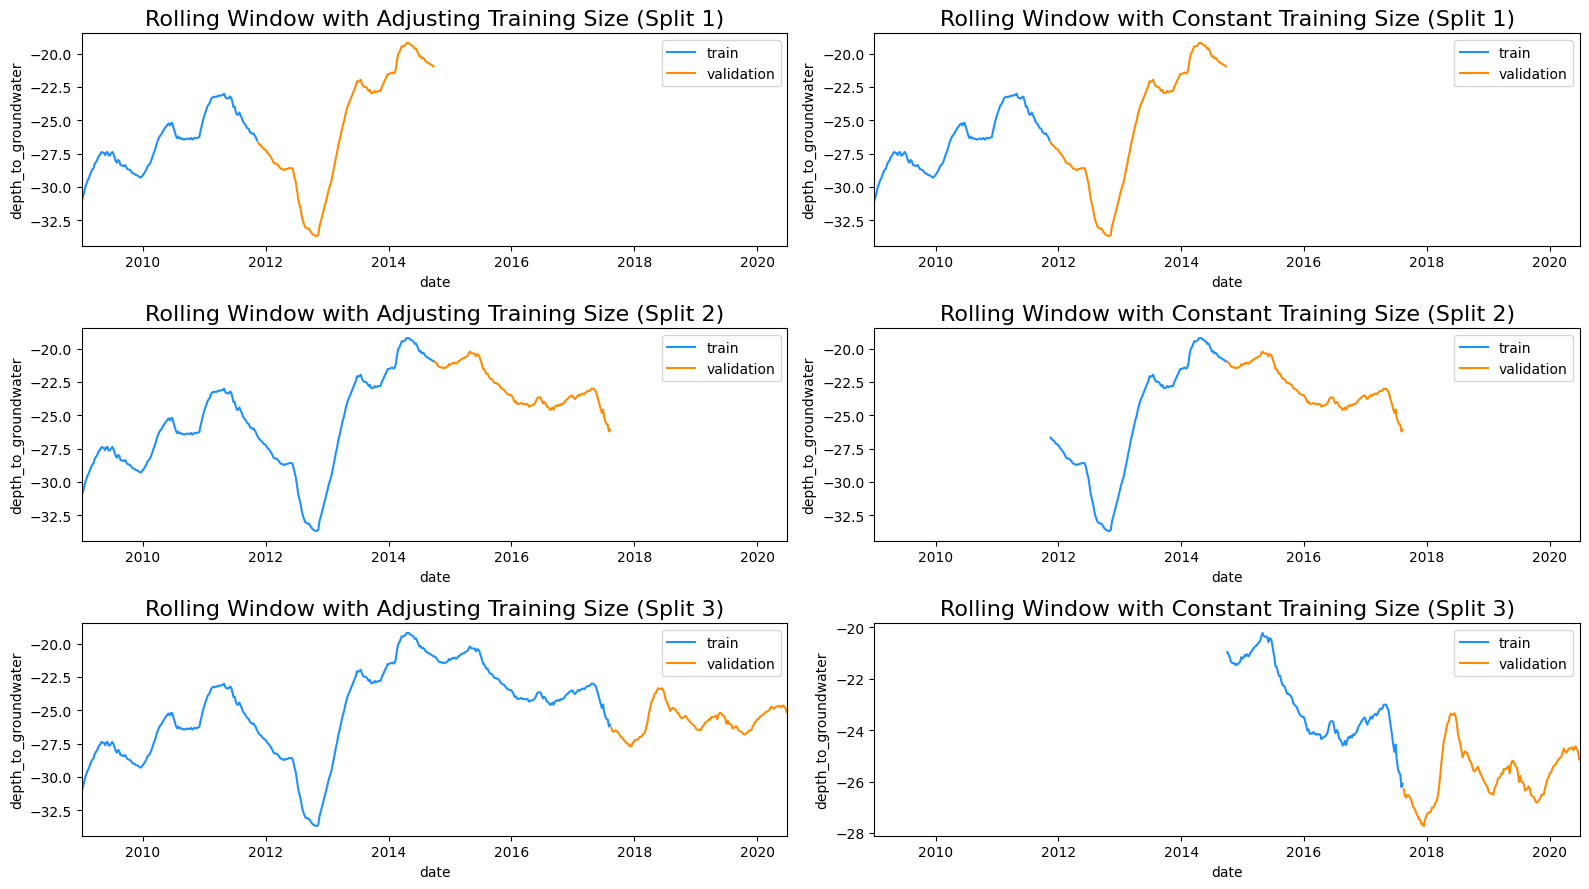

In [39]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

Univariate time series

In [40]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


Prophet

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from colorama import init, Fore
init()


from prophet import Prophet

model = Prophet()
model.fit(train)

y_pred = model.predict(x_valid)

score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

Importing plotly failed. Interactive plots will not work.
03:00:42 - cmdstanpy - INFO - Chain [1] start processing
03:00:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1.1648666225418787


Visualization

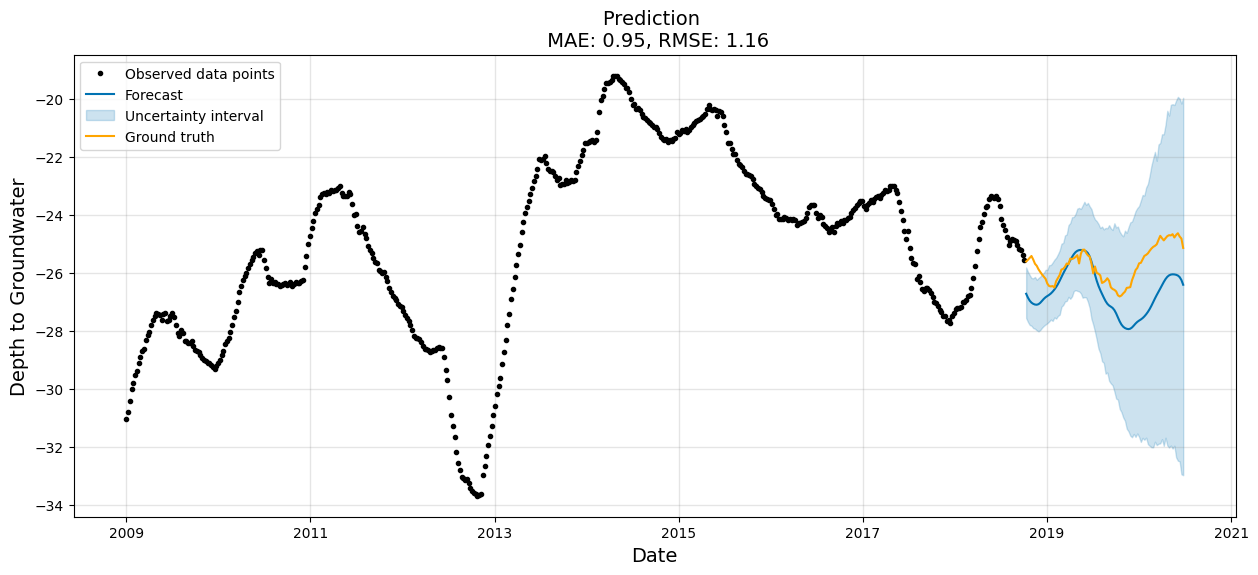

In [42]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

ARIMA model

In [43]:
from statsmodels.tsa.arima.model import ARIMA  
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

model = ARIMA(y_train, order=(1, 1, 1))
model_fit = model.fit()

forecast_result = model_fit.get_forecast(steps=90)  
y_pred = forecast_result.predicted_mean
conf = forecast_result.conf_int()  

score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 1.402624226430692


Visualization

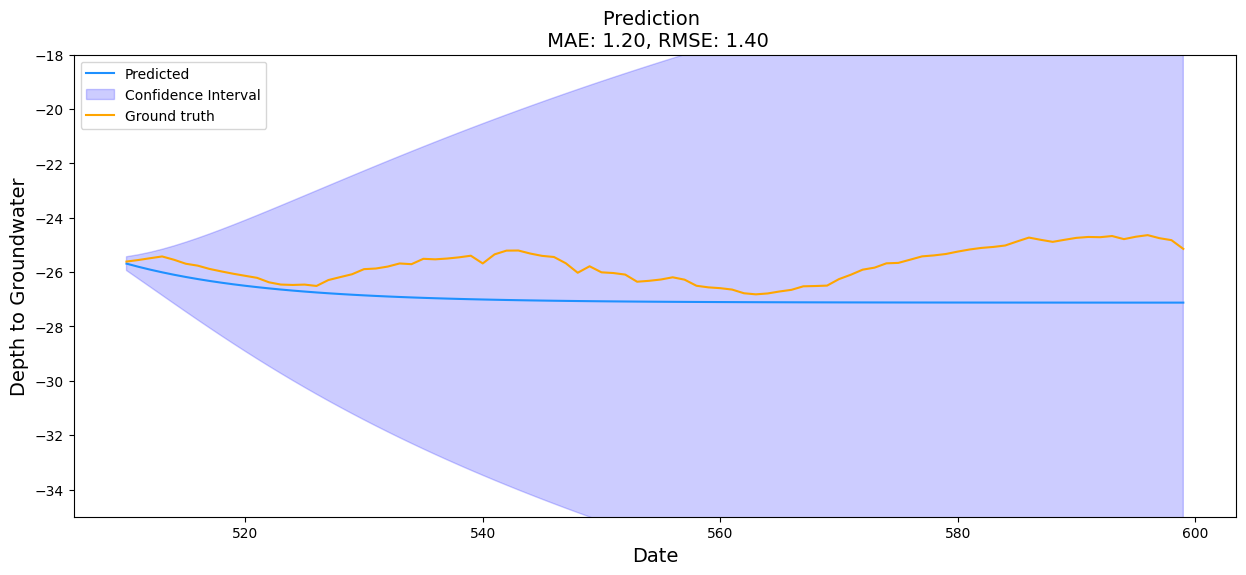

In [44]:
f, ax = plt.subplots(figsize=(15, 6))

forecast_result = model_fit.get_forecast(steps=len(y_valid))
y_pred = forecast_result.predicted_mean.squeeze() 
conf_int = forecast_result.conf_int()

y_valid = y_valid.squeeze()

ax.plot(y_valid.index, y_pred, color='dodgerblue', label='Predicted')
ax.fill_between(y_valid.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                color='blue', alpha=0.2, label='Confidence Interval')

sns.lineplot(x=y_valid.index, y=y_valid, ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Depth to Groundwater', fontsize=14)
ax.set_ylim(-35, -18)
ax.legend()

plt.show()

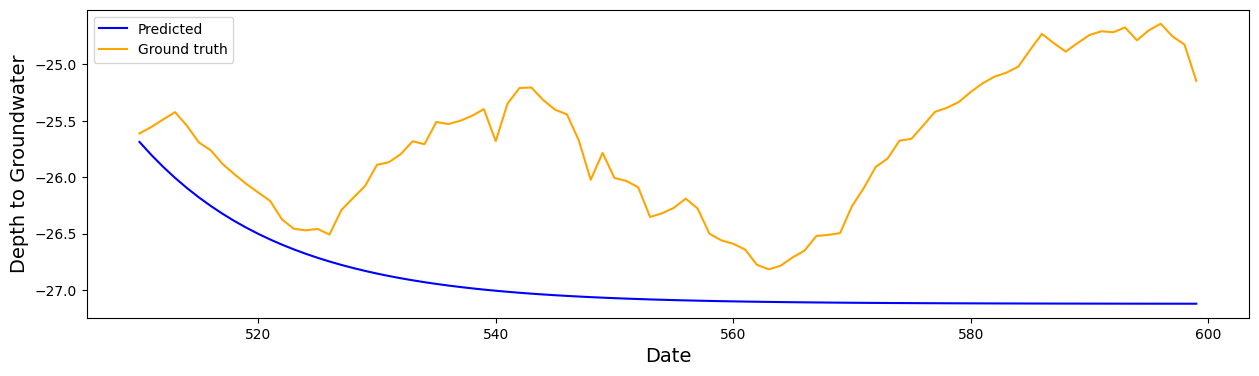

In [45]:
f, ax = plt.subplots(figsize=(15, 4))

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='Predicted')

sns.lineplot(x=x_valid.index, y=y_valid.squeeze(), ax=ax, color='orange', label='Ground truth')

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Depth to Groundwater', fontsize=14)

plt.show()

LSTM

In [46]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [47]:
look_back = 52
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(len(x_train), len(x_test))

406 90


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

2025-04-10 03:01:22.640872: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 03:01:22.904405: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 03:01:23.021334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744254083.326548    5083 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744254083.419462    5083 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744254084.027625    5083 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 1/5


2025-04-10 03:01:27.442931: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


406/406 ━━━━━━━━━━━━━━━━━━━━ 15:21 2s/step - loss: 0.186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0728  ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.052 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.044 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.041 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.038 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.035 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.034 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.033 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.033 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.032 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.031 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.030 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.029 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.028 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.026 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.025 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.024 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.023 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.022 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.022 ━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,195 (1.64 MB)

 Trainable params: 143,731 (561.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 287,464 (1.10 MB)

In [49]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 468ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
RMSE: 0.5226004090721983


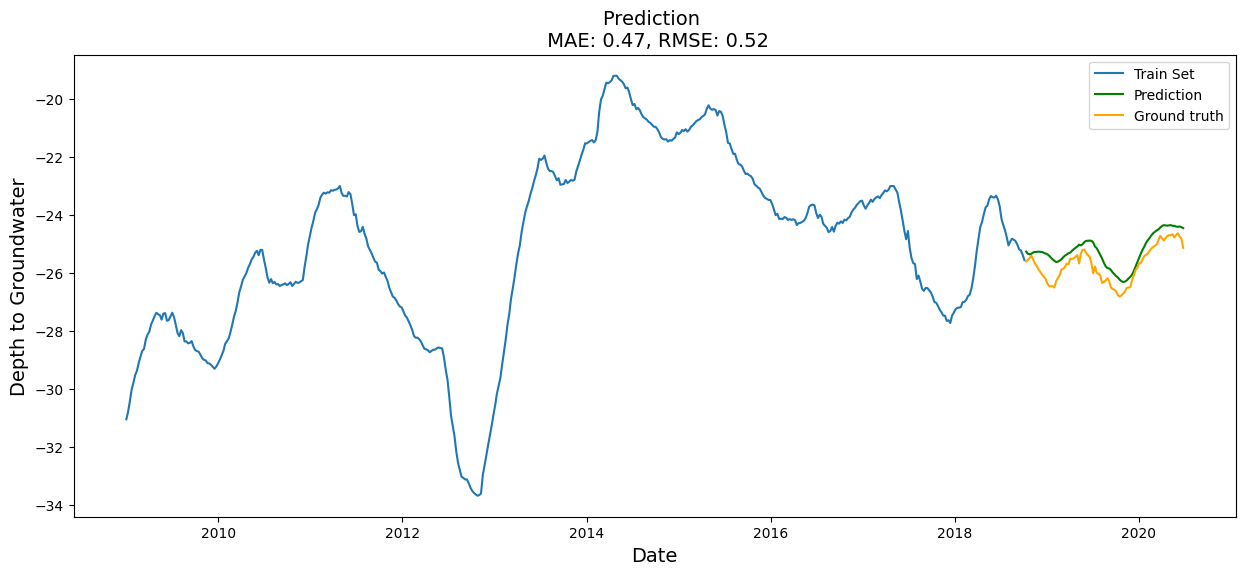

In [50]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

Models for Multivariate Time Series

In [51]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


In [52]:
from prophet import Prophet

model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')

model.fit(train)

y_pred = model.predict(x_valid)

score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

03:02:43 - cmdstanpy - INFO - Chain [1] start processing
03:02:43 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.9806231219261384


Visualization

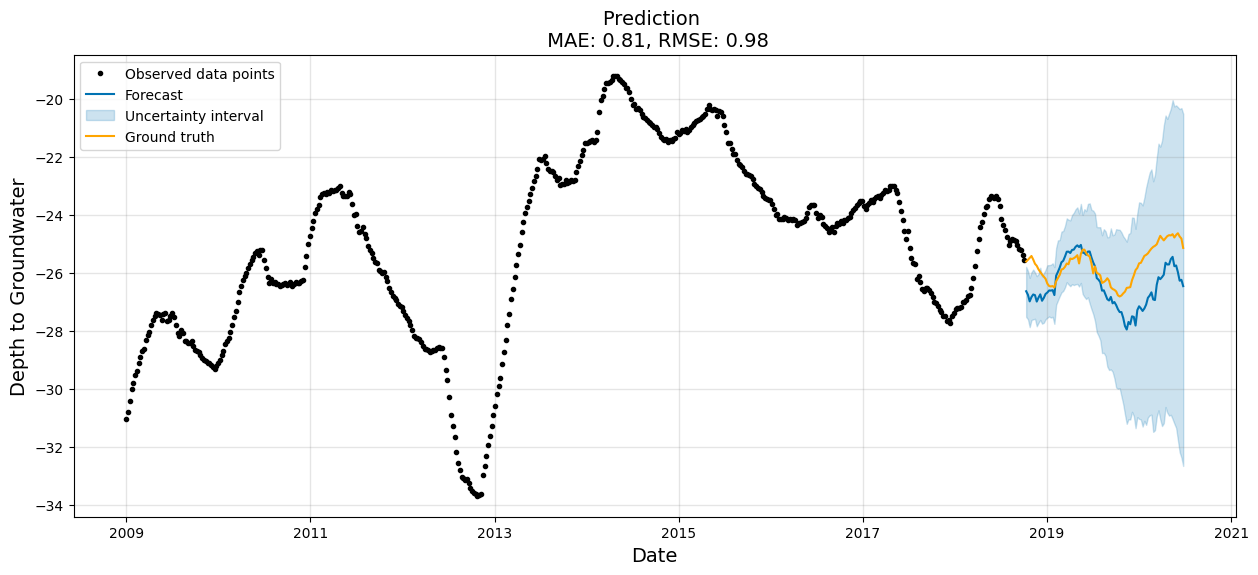

In [53]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

Based on the analysis of the models' performance over a one-year period, the most effective results were observed in the Multivariate Prophet and LSTM models.